# Labelling data as COVID related/unrelated

In this notebook I'm going to train a classifier able to detect whether a certain post is talking about COVID-19 or not. To create a labeled dataset, I used the 'China' subreddit, selecting posts from before 1st December 2019 to generate non COVID related posts and selecting posts labeled as '冠状病毒 | Coronavirus' for the others. After looking at the amount of data from these two sources, I decided to extend the research of coronavirus related posts to other subreddits that we know are focused on COVID-19.

## Importing and cleaning the datasets

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

These are the raw dataset, directly gathered from Reddit.

In [59]:
base_path = 'D:\Politecnico\Tesi\Script\Reddit crawling\Dataset\\'
df_pre_virus = pd.read_csv(base_path + 'ChinaBeforeCOVID.csv', low_memory = False)
df_post_virus = pd.read_csv(base_path + 'China.csv', low_memory = False)

df_covid_subreddit = pd.read_csv(base_path + 'PostCovid.csv', low_memory = False)

In [60]:
print("Length dataset pre-outbreak:  "  + str(len(df_pre_virus)))
print("Length dataset post-outbreak: "  + str(len(df_post_virus) + len(df_covid_subreddit)))

Length dataset pre-outbreak:  134367
Length dataset post-outbreak: 324315


Let's clean them up.

In [62]:
df_pre_virus.drop(df_pre_virus.columns.difference(['title','is_self','selftext','score','url','full_link','domain']), axis = 1, inplace = True)
df_post_virus.drop(df_post_virus.columns.difference(['title','is_self','selftext','score','url','full_link','domain','link_flair_text']), axis = 1, inplace = True)
df_covid_subreddit.drop(df_covid_subreddit.columns.difference(['title','is_self','selftext','score','url','full_link','domain']), axis = 1, inplace = True)

In [64]:
df_pre_virus = df_pre_virus[df_pre_virus['score'] > 7]
df_post_virus = df_post_virus[df_post_virus['link_flair_text'] == '冠状病毒 | Coronavirus']
df_covid_subreddit = df_covid_subreddit[df_covid_subreddit['score'] >= 5]

Now let's label them accordingly and merge them together.

In [63]:
df_pre_virus['covid_related'] = 0
df_post_virus['covid_related'] = 1
df_covid_subreddit['covid_related'] = 1

In [65]:
df = pd.concat([df_pre_virus, df_post_virus, df_covid_subreddit])
df.reset_index(inplace = True)
df.drop(columns = ['index', 'link_flair_text'], inplace = True)

To make the work easier later, I will merge title and text of each submission.

In [66]:
def createText(row):
    text = row['title']
    if(row['is_self']):
        text += str(" ") + str(row['selftext'])
    return text

In [67]:
df['text'] = df.apply(createText, axis = 1)
df.drop(df.columns.difference(['url','full_lin','domain','text','covid_related']), axis = 1, inplace = True)

## Exploratory data analysis and text preparation

Covid unrelated posts are a bit more than related ones. We might consider extending the latter even further later on.

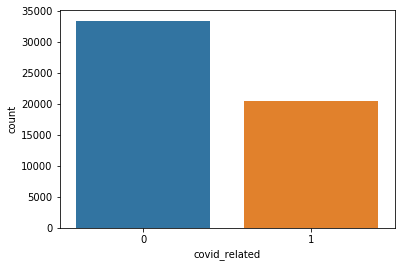

In [78]:
sns.countplot(data = df, x = 'covid_related')

In [68]:
df['len'] = df['text'].apply(len)

It doesn't seem like there's a great difference in the length of the posts.

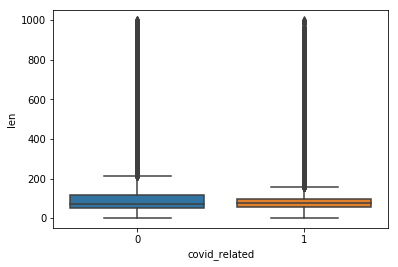

In [71]:
sns.boxplot(x = df[df['len'] < 1000]['covid_related'], y = df['len'])

## Text processing

We need to process the texts before performing text classidication. Here I'm implementing a simple type of pre processing, consisting of eliminating punctuation and classic stopwords.

In [51]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [74]:
import string
from nltk.corpus import stopwords

def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [77]:
df['text_processed'] = df['text'].apply(text_process)

## Classification

In [80]:
from sklearn.model_selection import train_test_split

text_train, text_test, label_train, label_test = train_test_split(df['text'], df['covid_related'], test_size=0.2)

In [82]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [83]:
pipeline.fit(text_train, label_train)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer=<function text_process at 0x0000011CE98AA268>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocesso...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [85]:
predictions = pipeline.predict(text_test)

In [86]:
from sklearn.metrics import classification_report
print(classification_report(predictions,label_test))

             precision    recall  f1-score   support

          0       0.99      0.88      0.93      7468
          1       0.79      0.98      0.87      3321

avg / total       0.93      0.91      0.91     10789



As first trial, the results are ok. It seems like we have too many false positives, but overall the model is good.

For sure, there is a lot of room for improvements:
 - Using lemmatization and stemmatization when processing the texts
 - Improving the pipeline, testing different classifiers
 - Looking for more features: are covid-related posts more likely to contain an image? Are they more likely to contain certain words?
 - Extending the datasets: right now all non-covid related posts come from a single subreddit, this should be improved; covid-related posts could be extended by scraping more data from the most richful subreddits or by finding new coronavirus related subreddits
 - Combining the pipeline with image analysis on top of text analysis